<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2022-2/notebooks/6a_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de máquinas de vectores de soporte mediante descenso por sub-gradiente
En esta libreta veremos cómo entrenar una máquina de vectores de soporte lineal usando el algoritmo PEGASOS (_Primal Estimated sub-GrAdient SOlver for SVM_)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt
cvxopt.solvers.options['show_progress'] = False

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

## Conjunto de datos
Probaremos nuestro SVM en la clasificación de 2 flores iris en base a su ancho y largo sepal.

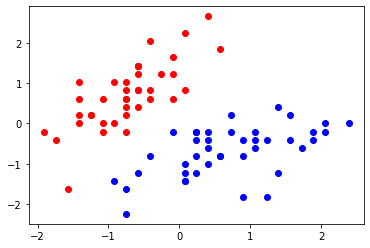

In [2]:
iris = datasets.load_iris()
    
subconj = np.where(iris['target'] < 2)
X = iris['data'][subconj]
X = X[:, :2]
y = iris['target'][subconj]
y[y == 0] = -1

perm = np.random.permutation(X.shape[0])
X = X[perm,:]
y = y[perm]

X_ent = X[:int(X.shape[0] * 0.8)]
y_ent = y[:int(X.shape[0] * 0.8)]

sc = StandardScaler()
X_ent = sc.fit_transform(X_ent)

plt.plot(X_ent[y_ent==1, 0], X_ent[y_ent==1, 1], 'bo')
plt.plot(X_ent[y_ent==-1, 0], X_ent[y_ent==-1, 1], 'ro')
plt.show()

Generamos nuestro conjunto de validación y lo reescalamos

In [3]:
X_val = X[int(X.shape[0] * 0.8):]
y_val = y[int(X.shape[0] * 0.8):]
X_val = sc.transform(X_val)

## SVM
Usamos la función de optimización cuadrática `qp` de la biblioteca [cvxopt](https://cvxopt.org/) para resolver el problema dual dado por 

\begin{equation*}
      \begin{split}
        \text{maximiza } & \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y^{(i)} y^{(j)}\underbrace{\left[\left(\mathbf{x}^{(i)}\right)^\top \mathbf{x}^{(j)} \right]}_{k(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})}\\
        \text{sujeto a } & 0 \leq \alpha_i \leq C, \forall i, \sum_{i=1}^n \alpha_i y^{(i)} = 0
      \end{split}
    \end{equation*}

In [4]:
class SVMDualQP:
  def __init__(self, C = 1, eps = 1e-5):
    self.C = 1
    self.eps = eps

  def prod(self, x):
    return [a * self.ys[i] * (self.xs[i].T @ x) for i,a in enumerate(self.alfas)]

  def fit(self, X, y):
    n = X.shape[0]
    d = X.shape[1]
  
    P = cvxopt.matrix(np.outer(y, y) * (X @ X.T), tc='d')
    q = cvxopt.matrix(np.ones(n) * -1)
    A = cvxopt.matrix(y_ent[np.newaxis, :], tc='d')
    f = cvxopt.matrix(0, tc='d')

    G = cvxopt.matrix(np.vstack((np.eye(n) * -1, np.eye(n))))
    h = cvxopt.matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))

    minimization = cvxopt.solvers.qp(P, q, G, h, A, f)
    a = np.ravel(minimization['x'])
    indvs = a > self.eps
    self.alfas = a[indvs]
    self.xs = X[indvs]
    self.ys = y[indvs]

    self.b = self.ys[0] - np.sum(self.prod(self.xs[0]))

  def project(self, X):
    y = np.zeros(X.shape[0])
    for i,e in enumerate(X):
      y[i] = np.sum(self.prod(e)) + self.b

    return y

  def predict(self, X):
    return np.sign(self.project(X))

Instanciamos nuestra clase y entrenamos nuestro clasificador

In [5]:
svm = SVMDualQP()
svm.fit(X_ent, y_ent)

Evaluamos el clasificador entrenado en el conjunto de validación:

In [6]:
pred_val = svm.predict(X_val)
print(f'Exactitud = {np.mean(pred_val  == y_val) * 100}%')

Exactitud = 100.0%


## PEGASOS
De formar alternativa, es posible entrenar una máquina de vectores de soporte lineal usando el algoritmo PEGASOS (_Primal Estimated sub-GrAdient SOlver for SVM_), el cual usa el subgradiente dado por

$$
\tilde{\nabla}E(\mathbf{w}, b) = 
\begin{cases}
0, & y^{(i)} \cdot (\mathbf{w}^\top \mathbf{x}^{(i)} + b) \geq 1\\
y^{(i)} \cdot \mathbf{x}^{(i)}, & y^{(i)} \cdot (\mathbf{w}^\top \mathbf{x}^{(i)} + b) < 1
\end{cases}
$$


In [7]:
def subgradiente(w, xi, yi):
  if yi * (w.T @ xi) < 1:
    return yi * xi
  else:
    return 0

El procedimiento general del algoritmo PEGASOS es el que sigue:

* Inicializamos $\mathbf{w}$ y $b$ a $0$
* Para $t = 1,\ldots, T$ realizar
  * Elige ejemplo $\{x^{(i)}, y^{(i)}\}$ aleatoriamente
  * $\eta^{t} = \frac{1}{\lambda \cdot t}$
  * Si $y^{(i)} (\mathbf{w}_t^\top \mathbf{x}^{(i)} + b) < 1$, entonces
$$
  \mathbf{w}^{t+1} = (1 - \eta^t\cdot \lambda)\cdot \mathbf{w}^t + \eta^t\cdot y^{(i)} \cdot \mathbf{x}^{(i)}
$$

  * En caso contrario

$$
  \mathbf{w}^{t+1} = (1 - \eta^t\cdot \lambda)\cdot \mathbf{w}^t
$$

In [8]:
def pegasos(X, y, n_iter = 1000, l = 0.01):
  Xd = np.column_stack((np.ones(X.shape[0]), X))
  n = Xd.shape[0]
  w = np.zeros(Xd.shape[1])

  t = 0
  for i in range(n_iter):
    perm = np.random.permutation(n)
    for j in range(n):
      t += 1
      decay = 1.0 / t
      eta_t = decay  / l
      w = (1 - decay) * w + eta_t * subgradiente(w, Xd[perm[j]],  y[perm[j]])

  return w

Entrenamos nuestro modelo usando el algoritmo PEGASOS

In [9]:
w = pegasos(X_ent, y_ent, l = 0.001)

Predecimos las clases de los datos de validación y evaluamos su exactitud![texto alternativo](https://)

In [10]:
X_val = np.column_stack((np.ones(X_val.shape[0]), X_val))
y_val_predicha = np.sign(X_val @ w.T)
print(f'Exactitud = {np.mean(y_val == y_val_predicha) * 100}%')    

Exactitud = 100.0%


Imprimimos los pesos encontrados

In [11]:
print('w_1 = {0}, w_2 = {1}, b = {2}'.format(w[1], w[2], w[0]))

w_1 = 3.83662235796837, w_2 = -2.5960593159225858, b = 0.8250000000000047


Visualizamos el híperplano y los vectores de soporte

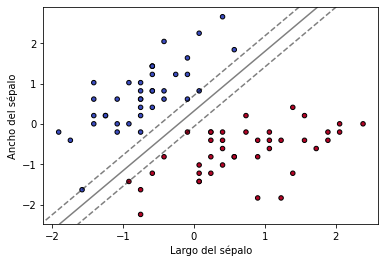

In [12]:
fig, ax = plt.subplots()
ax.scatter(X_ent[:, 0], X_ent[:, 1], c=y_ent, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))

Xr = np.c_[xx.ravel(), yy.ravel()]
Xr = np.column_stack((np.ones(Xr.shape[0]), Xr))

Z = Xr @ w.T
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
ax.set_xlabel('Largo del sépalo')
ax.set_ylabel('Ancho del sépalo')
plt.show()

## Ejercicio
+ Modifica la clase `SVMDualQP` para incluir un kernel.
+ Prueba con diferentes valores de $\lambda$.